# Introduction

In this proyect I developed a model to predict the sales of different products based on the data of almost 2 years. I use MAPE to measure the quality of the model.

In [1]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

C:\Users\OPERADOR\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [7]:
df = pd.read_csv(r'C:\Users\OPERADOR\Desktop\cienciadedatos\store_data.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()

df['date'] = pd.to_datetime(df['date'], format="%d/%m/%Y")

In [8]:
min(df['date']), max(df['date'])


(Timestamp('2013-01-01 00:00:00'), Timestamp('2014-08-13 00:00:00'))

In [9]:
df.head()


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   id           1048575 non-null  int64         
 1   date         1048575 non-null  datetime64[ns]
 2   store_nbr    1048575 non-null  int64         
 3   family       1048575 non-null  object        
 4   sales        1048575 non-null  float64       
 5   onpromotion  1048575 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 48.0+ MB


In [11]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
id,1048575.00,524287.00,0.00,262143.50,524287.00,786430.50,1048574.00,302697.67
date,1048575,2013-10-22 02:30:51.946499328,2013-01-01 00:00:00,2013-05-28 00:00:00,2013-10-22 00:00:00,2014-03-19 00:00:00,2014-08-13 00:00:00,NaN
store_nbr,1048575.00,27.49,1.00,14.00,27.00,41.00,54.00,15.58
sales,1048575.00,244.53,0.00,0.00,1.00,120.00,46271.00,806.59
onpromotion,1048575.00,0.11,0.00,0.00,0.00,0.00,196.00,2.38


In [12]:
agg_df = df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])


In [13]:
agg_df.head()


,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.00
33,2013-01-02,AUTOMOTIVE,255.00
66,2013-01-03,AUTOMOTIVE,161.00
99,2013-01-04,AUTOMOTIVE,169.00
132,2013-01-05,AUTOMOTIVE,342.00


In [14]:
total_sales_df = agg_df.pivot(index='date',columns='family', values='sales')
total_sales_df.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,EGGS,FROZEN FOODS,GROCERY I,GROCERY II,HARDWARE,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME APPLIANCES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,LINGERIE,"LIQUOR,WINE,BEER",MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.00,0.00,2.00,810.00,0.00,180.59,0.00,186.00,143.00,71.09,46.00,29.65,700.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,5.00,105.00,0.00,110.80,25.00,0.00,0.00,42.64,37.85,0.00,0.00,0.00
2013-01-02,255.00,0.00,207.00,72092.00,0.00,26246.32,0.00,74629.00,23381.00,15754.50,10932.00,7115.39,202020.00,1476.00,46.00,0.00,0.00,21.00,0.00,0.00,121.00,469.00,2411.00,0.00,20871.46,17204.00,0.00,0.00,13975.88,5338.11,0.00,0.00,1526.75
2013-01-03,161.00,0.00,125.00,52105.00,0.00,18456.48,0.00,55893.00,18001.00,11172.45,7358.00,4760.81,144878.00,1048.00,37.00,0.00,0.00,15.00,0.00,0.00,83.00,366.00,2476.00,0.00,16597.40,12568.00,0.00,0.00,10674.39,3591.39,0.00,0.00,1094.31
2013-01-04,169.00,0.00,133.00,54167.00,0.00,16721.97,0.00,52064.00,18148.00,10143.21,6760.00,4525.93,135754.00,1031.00,57.00,0.00,0.00,13.00,0.00,0.00,127.00,382.00,4796.00,0.00,21625.96,11303.00,0.00,0.00,10772.52,4472.97,0.00,0.00,1293.12
2013-01-05,342.00,0.00,191.00,77818.00,0.00,22367.76,0.00,70128.00,23082.00,13734.95,8576.00,5781.61,188356.00,1273.00,87.00,0.00,0.00,11.00,0.00,0.00,180.00,458.00,6715.00,0.00,20879.09,16819.00,0.00,0.00,13475.01,5830.07,0.00,0.00,1245.64


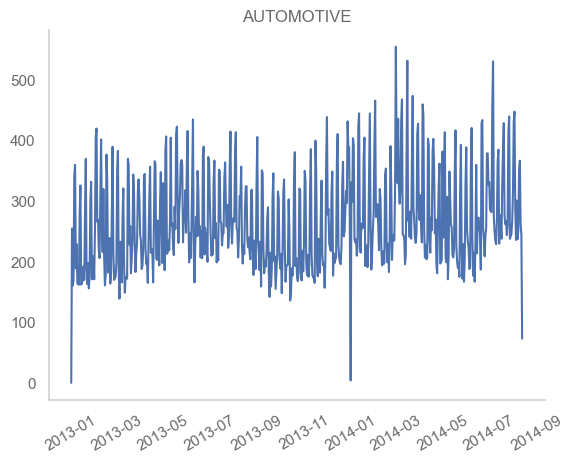

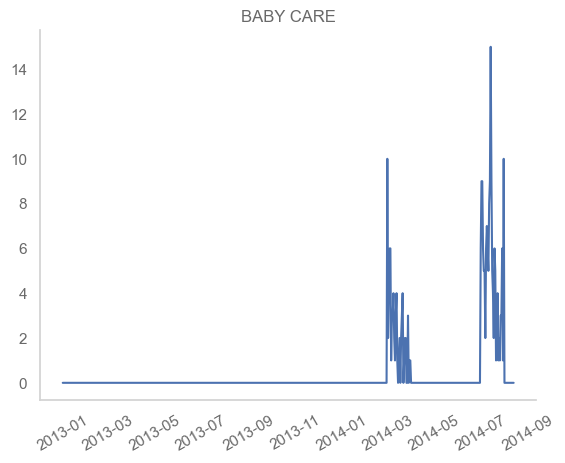

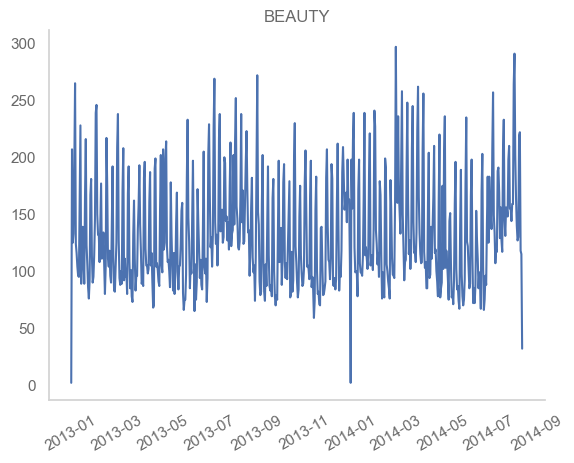

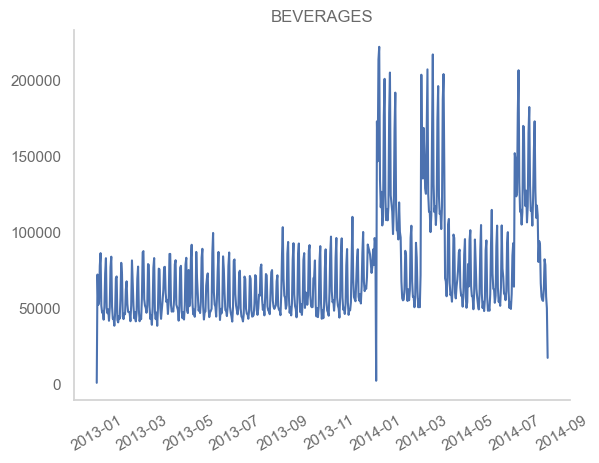

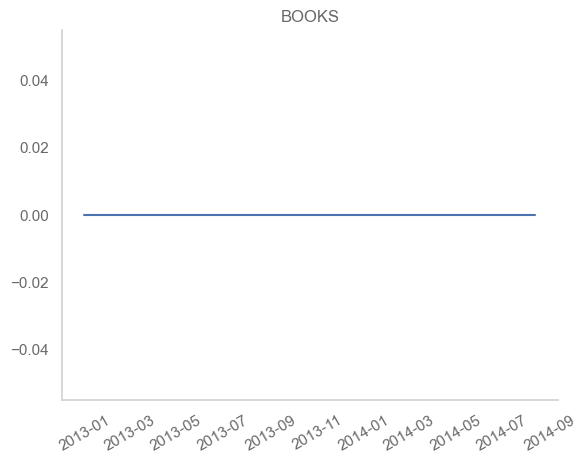

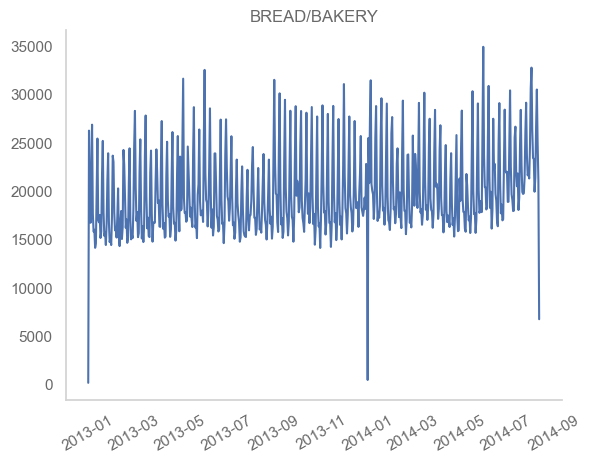

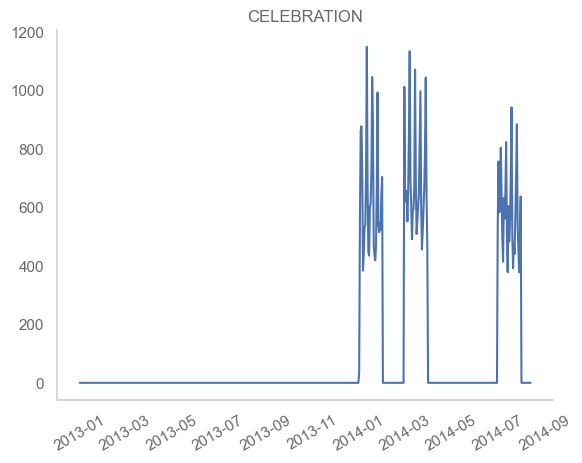

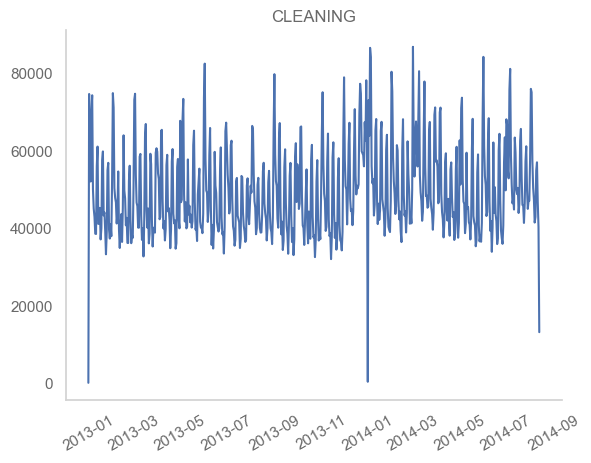

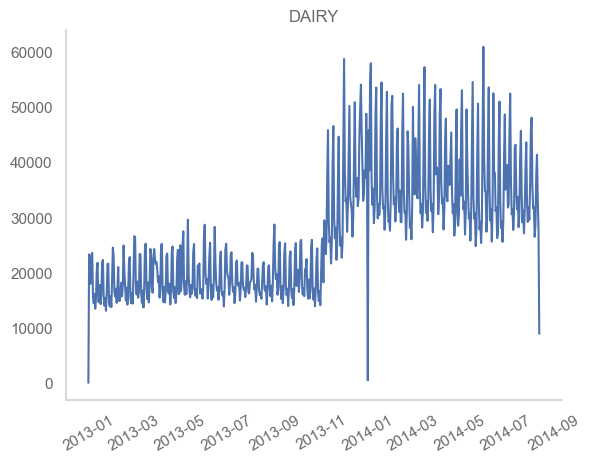

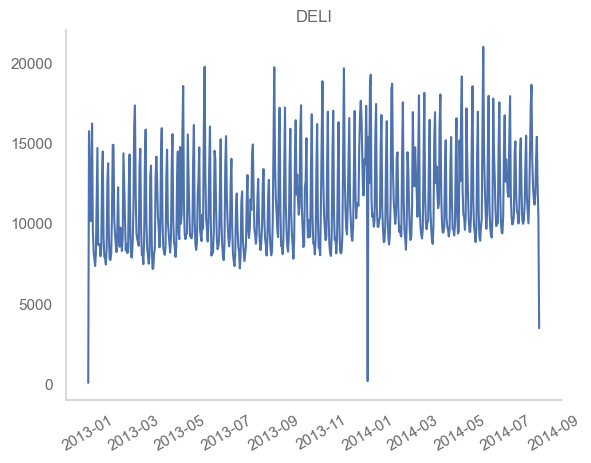

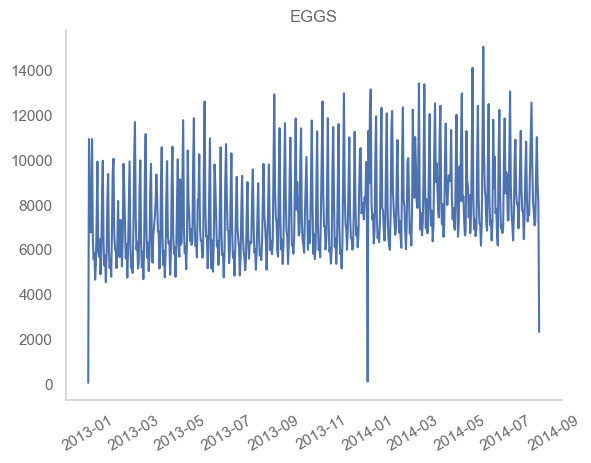

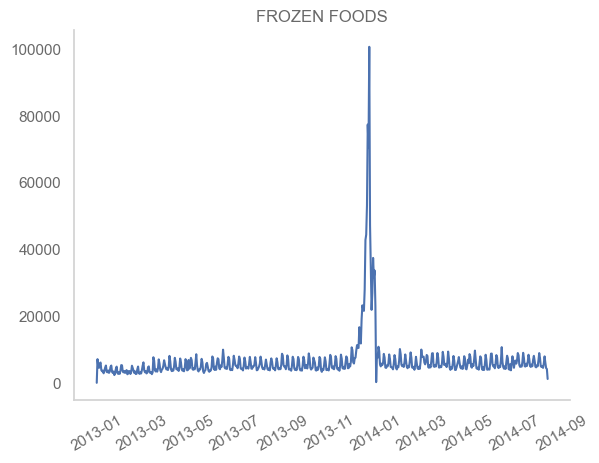

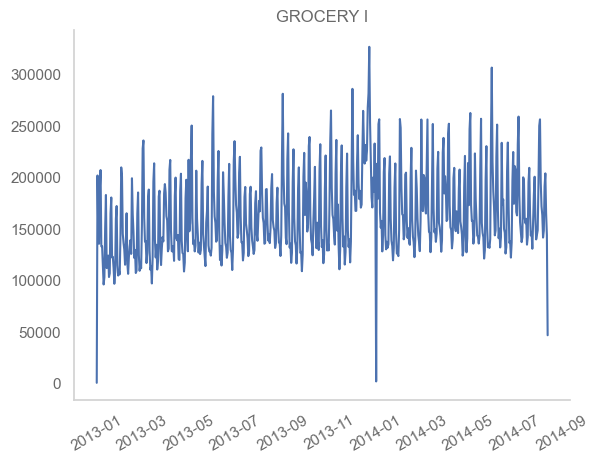

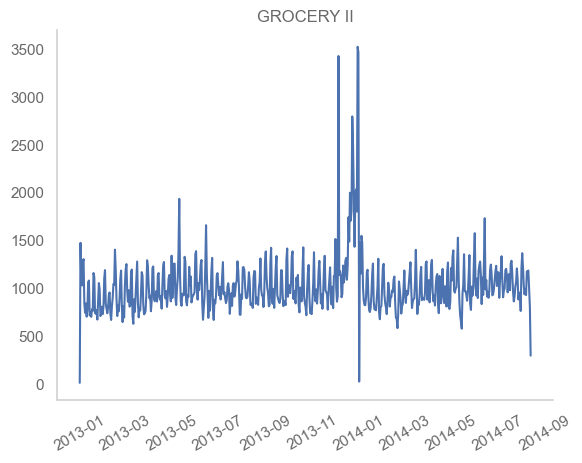

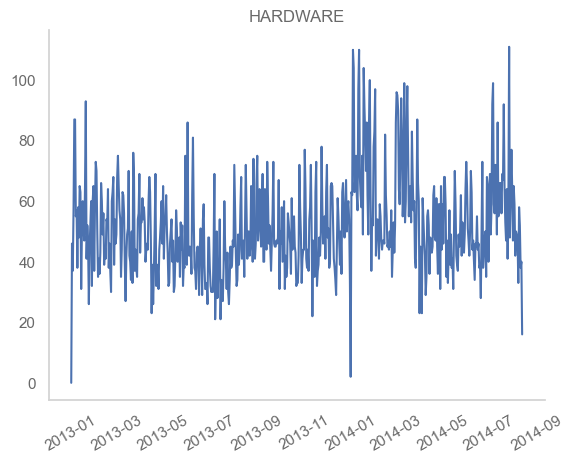

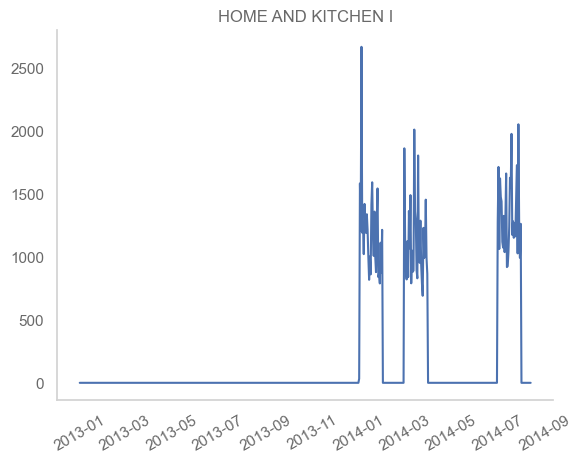

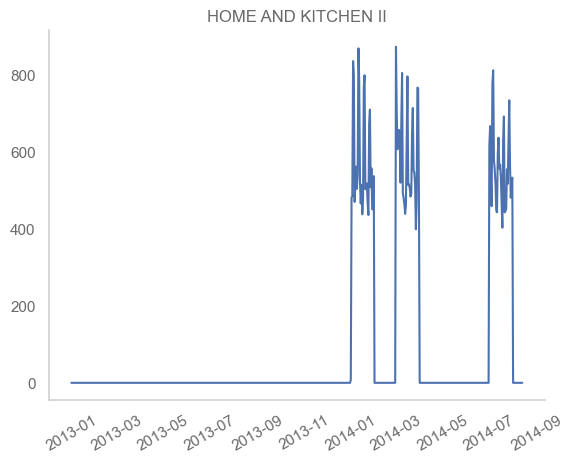

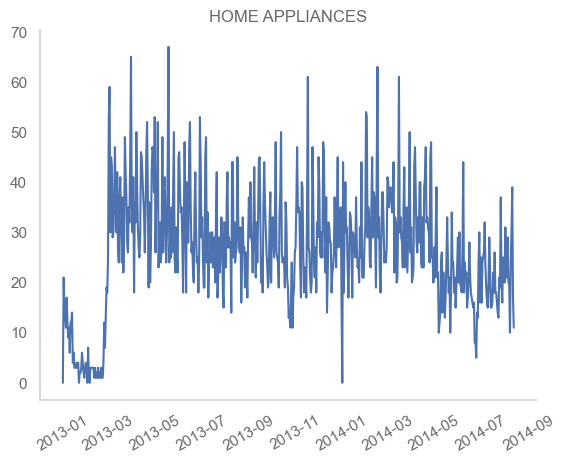

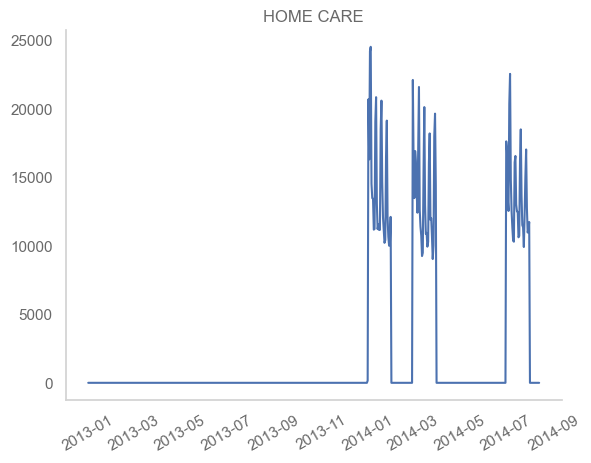

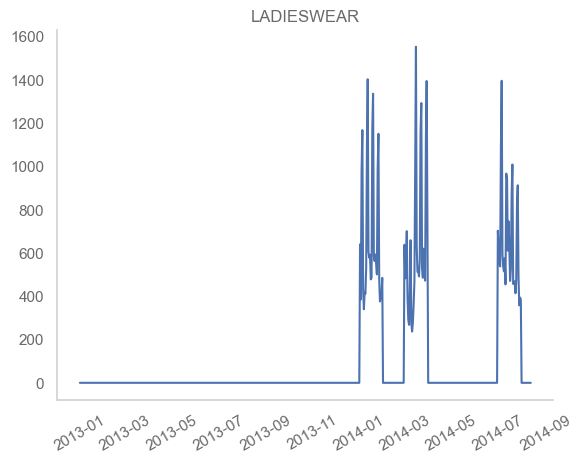

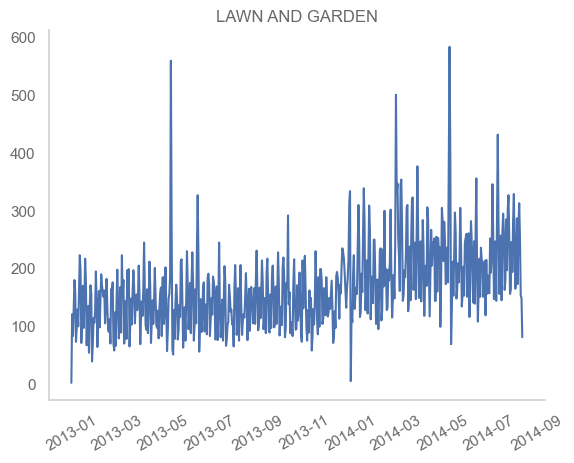

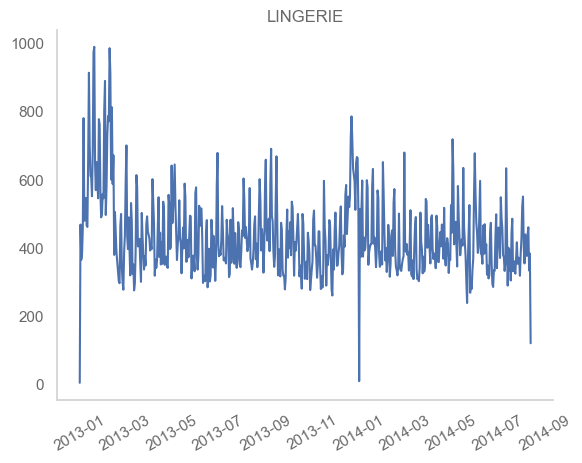

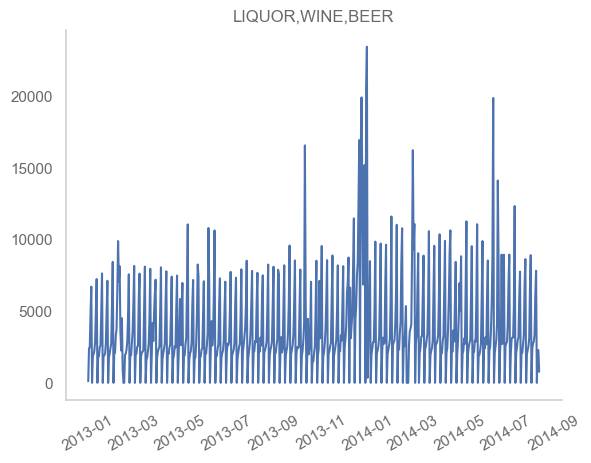

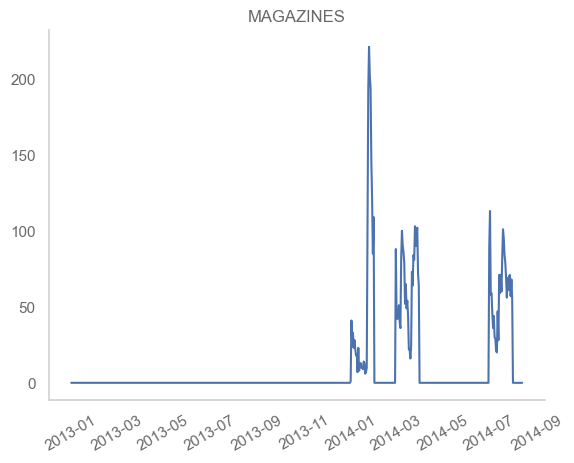

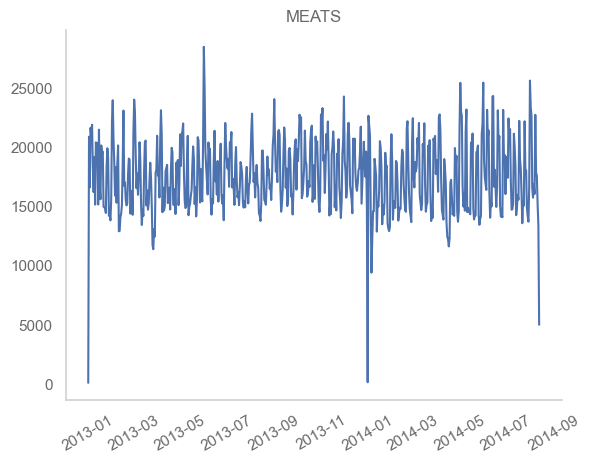

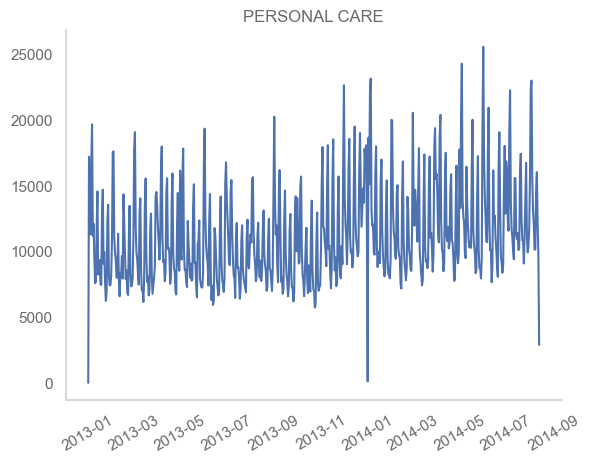

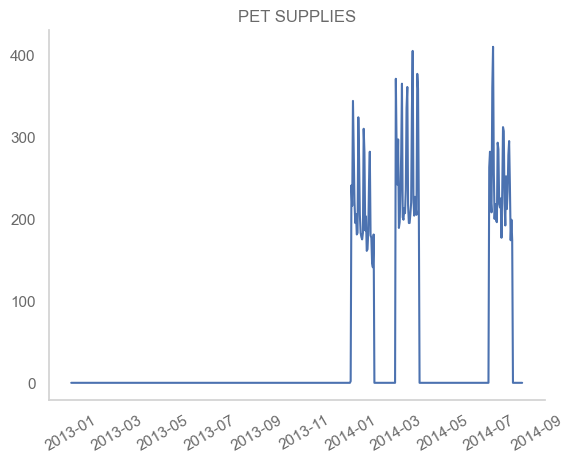

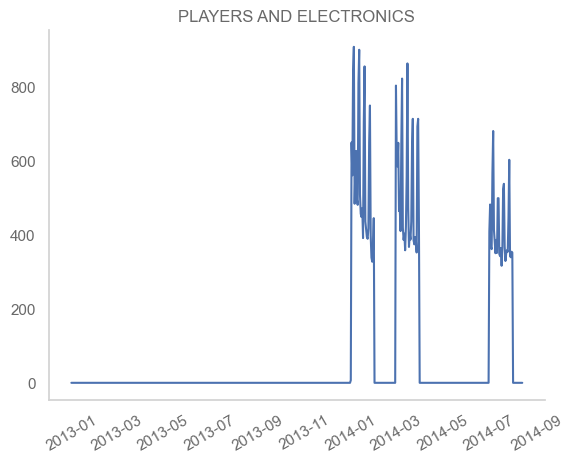

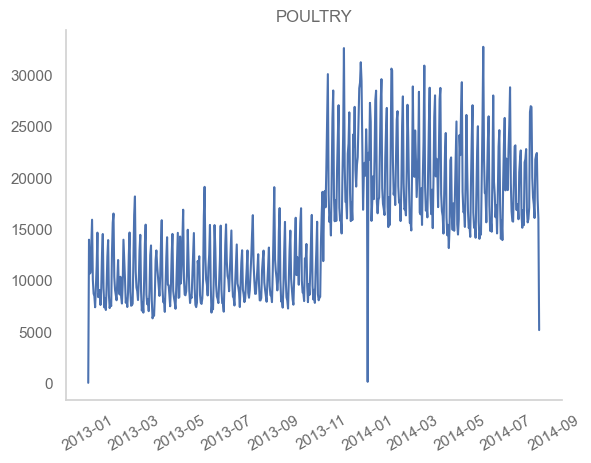

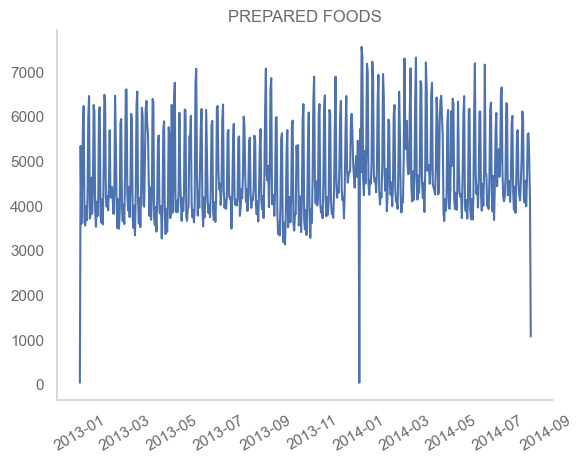

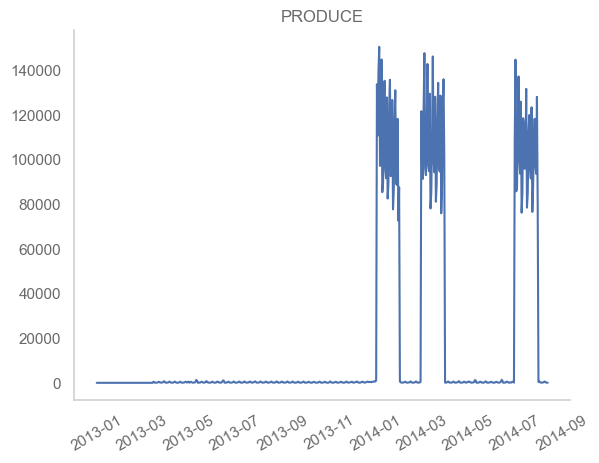

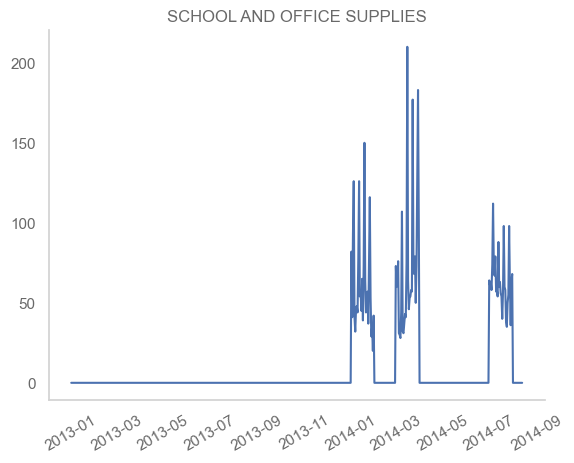

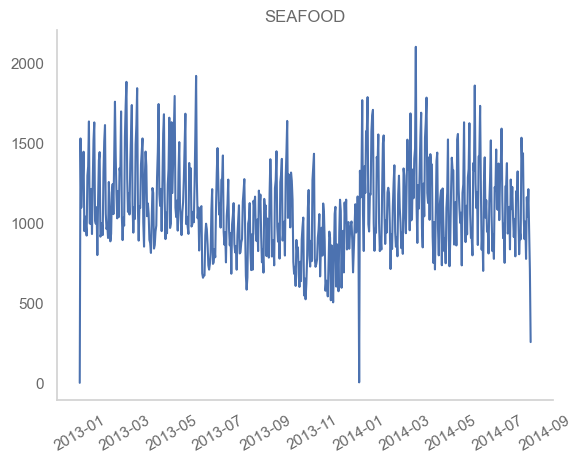

In [25]:
for column in total_sales_df.columns:
    plt.plot(total_sales_df[column])
    plt.xticks(rotation=30)
    plt.title(column)
    plt.show()

In [16]:
missing_data(total_sales_df)


,Total,Percent,Types
family,,,
AUTOMOTIVE,0,0.00,float64
BABY CARE,0,0.00,float64
BEAUTY,0,0.00,float64
BEVERAGES,0,0.00,float64
BOOKS,0,0.00,float64
BREAD/BAKERY,0,0.00,float64
CELEBRATION,0,0.00,float64
CLEANING,0,0.00,float64
DAIRY,0,0.00,float64


Let's group these different categories by the volume of data. The higher volume data the better for forecasting since you can forecast past the noise and end up with lower error bars. This will also let us visualize the forecasts on similar scales so that we can figure out if timeseries modeling will work for the categories since timeseries highly depends on seasonal data of a certain variation (addtitive, multiplicative).

### Category Grouping


In [18]:
#lets break it down by thirds for low, mid, high
avg_daily_sales = total_sales_df.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(total_sales_df.apply(np.mean, axis=0).sort_values(),[33,66])

In [19]:
low_vol_columns = list(avg_daily_sales[avg_daily_sales<=low].index)
mid_vol_columns = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index
high_vol_columns = avg_daily_sales[avg_daily_sales>=mid].index

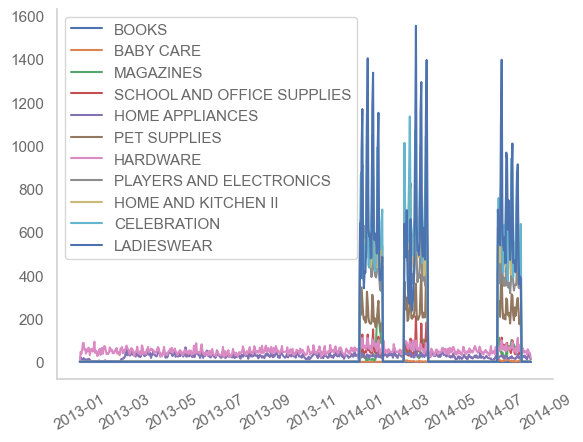

In [24]:
#total_sales_df[low_vol_columns].plot.line()
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns, loc='best') #, bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)

plt.show()

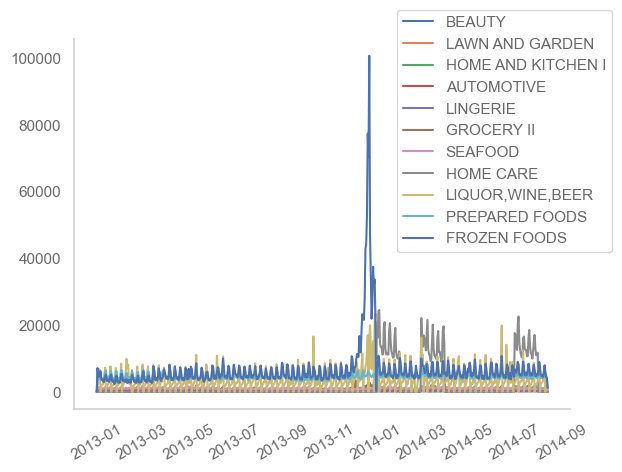

In [23]:
plt.plot(total_sales_df[mid_vol_columns])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

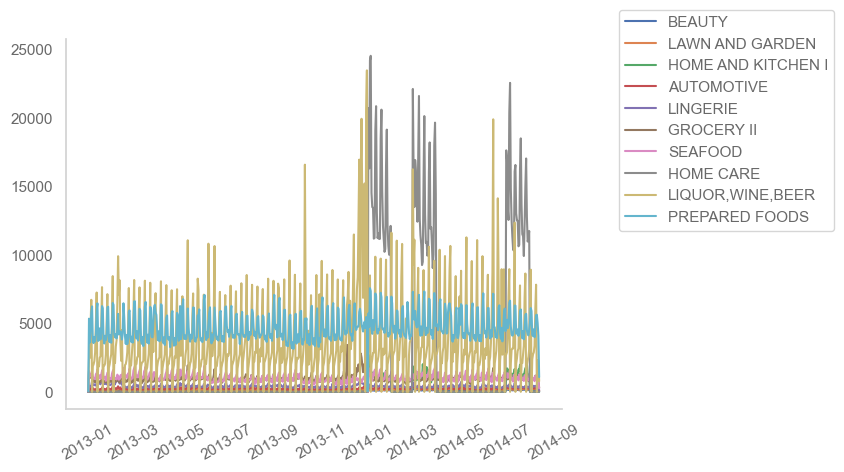

In [27]:
plt.plot(total_sales_df[mid_vol_columns].drop(columns='FROZEN FOODS'))
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

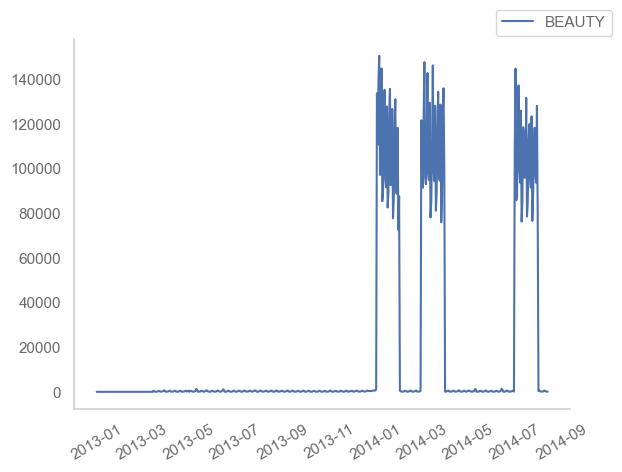

In [26]:
plt.plot(total_sales_df['PRODUCE'])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

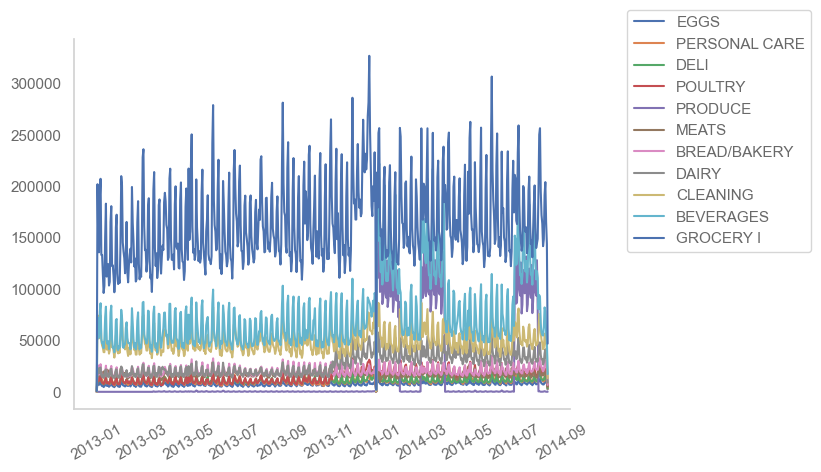

In [28]:
plt.plot(total_sales_df[high_vol_columns])
plt.legend(high_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

## Let's test things out with a high volume metric first to see if things work. Let's test with "PRODUCE."


In [29]:
#setting variables
feature = 'PRODUCE'
prediction_days = 30

In [30]:
df = total_sales_df[[feature]].reset_index()
df.head()

family,date,PRODUCE
0,2013-01-01,0.00
1,2013-01-02,0.00
2,2013-01-03,0.00
3,2013-01-04,0.00
4,2013-01-05,0.00


In [34]:
#Variables

forecast_start_dt = date(2014,7,1) #data set ends of (2014,8,13)
forecast_start_date = (forecast_start_dt).strftime("%Y-%m-%d") 
print(forecast_start_date)




2014-07-01


In [35]:
#PROPHET MODEL

df_copy = df.copy()
df_copy = df_copy.rename(columns={'date': 'ds', feature: 'y'})
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

df_copy['ds'] = pd.to_datetime(df_copy['ds'])

train_set = df_copy[(df_copy['ds'] < forecast_start_date) ]

m = Prophet()

m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

13:20:31 - cmdstanpy - INFO - Chain [1] start processing
13:20:33 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
predicted_df.head(10)


,ds,yhat
545,2014-07-01,6979.19
546,2014-07-02,10582.81
547,2014-07-03,6555.51
548,2014-07-04,6922.25
549,2014-07-05,10392.82
550,2014-07-06,11456.37
551,2014-07-07,6574.48
552,2014-07-08,5589.98
553,2014-07-09,9193.60
554,2014-07-10,5166.29


variable considerations for prophet model: growth, changepoint_prior_scale, changepoint_range, yearly/weekly/daily seasonality, seasonality mode, holidays

In [37]:
df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)

In [38]:
predicted_df


,ds,yhat,ytrue
0,2014-07-01,6979.19,108260.84
1,2014-07-02,10582.81,144791.22
2,2014-07-03,6555.51,85810.32
3,2014-07-04,6922.25,87788.85
4,2014-07-05,10392.82,116791.47
5,2014-07-06,11456.37,137272.69
6,2014-07-07,6574.48,100024.03
7,2014-07-08,5589.98,93731.14
8,2014-07-09,9193.60,125960.13
9,2014-07-10,5166.29,76247.77


In [39]:
mape(predicted_df['ytrue'], predicted_df['yhat'])


94.21065518920629

# Cross Validation with Prophet


Find the "best" parameters by testing over various periods of time with those parameters (cross-validation).



In [40]:
m = Prophet()
m.fit(train_set)
df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days')

13:25:49 - cmdstanpy - INFO - Chain [1] start processing
13:25:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|                                                                                            | 0/6 [00:00<?, ?it/s]13:25:50 - cmdstanpy - INFO - Chain [1] start processing
13:25:50 - cmdstanpy - INFO - Chain [1] done processing
 17%|██████████████                                                                      | 1/6 [00:00<00:02,  2.07it/s]13:25:50 - cmdstanpy - INFO - Chain [1] start processing
13:25:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|████████████████████████████                                                        | 2/6 [00:00<00:01,  2.07it/s]13:25:51 - cmdstanpy - INFO - Chain [1] start processing
13:25:51 - cmdstanpy - INFO - Chain [1] done processing
 50%|██████████████████████████████████████████                                          | 3/6 [00:01<00:01,  2.28it/s]13:25:51 - cmdstanpy - INFO - Chain [1] start processing
13:25:51 - cmds

In [41]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,6920974622.36,83192.40,77082.65,319.86,148.78,1.81,0.17
1,4 days,7206952812.43,84893.77,78175.85,361.71,241.64,1.81,0.17
2,5 days,6890228841.31,83007.40,75926.74,426.80,264.69,1.80,0.17
3,6 days,6077174339.03,77956.23,71955.81,424.29,279.74,1.78,0.17
4,7 days,6343249815.69,79644.52,74019.17,371.27,279.74,1.80,0.17
5,8 days,6315553007.67,79470.45,74223.20,316.53,122.75,1.80,0.17
6,9 days,6173615089.99,78572.36,73226.68,243.45,122.75,1.79,0.17
7,10 days,5806082075.72,76197.65,71777.50,291.81,122.75,1.78,0.17
8,11 days,6321797393.02,79509.73,73384.76,339.88,198.02,1.77,0.17
9,12 days,6406057210.05,80037.85,73401.60,405.07,198.02,1.77,0.17


In [42]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,6920974622.36,83192.40,77082.65,319.86,148.78,1.81,0.17
1,4 days,7206952812.43,84893.77,78175.85,361.71,241.64,1.81,0.17
2,5 days,6890228841.31,83007.40,75926.74,426.80,264.69,1.80,0.17
3,6 days,6077174339.03,77956.23,71955.81,424.29,279.74,1.78,0.17
4,7 days,6343249815.69,79644.52,74019.17,371.27,279.74,1.80,0.17


In [43]:
df_p.tail()


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
23,26 days,6896005592.94,83042.19,75937.38,429.46,265.55,1.76,0.22
24,27 days,6574679437.25,81084.40,74242.28,426.43,265.58,1.76,0.22
25,28 days,6749274898.42,82153.97,76637.71,388.88,286.23,1.78,0.17
26,29 days,5980470038.77,77333.50,70809.65,300.58,110.85,1.68,0.22
27,30 days,5164007208.98,71861.03,64776.60,207.79,121.94,1.64,0.22


In [44]:
df_cv['mape'] = (df_cv['y']-df_cv['yhat'])/(df_cv['y'])*100
df_cv['overestimate'] = df_cv['yhat'] > df_cv['y'] 

df_cv.sort_values('mape',ascending=False).head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
6,2014-01-08,214.80,55.44,390.59,144872.59,2014-01-01,99.85,False
0,2014-01-02,215.59,54.41,393.09,133744.25,2014-01-01,99.84,False
13,2014-01-15,218.99,54.49,392.79,127888.62,2014-01-01,99.83,False
4,2014-01-06,171.07,10.11,330.07,97197.10,2014-01-01,99.82,False
20,2014-01-22,223.19,72.33,381.63,126741.28,2014-01-01,99.82,False
5,2014-01-07,183.53,20.56,354.78,101097.33,2014-01-01,99.82,False
11,2014-01-13,175.26,6.22,343.37,95336.39,2014-01-01,99.82,False
27,2014-01-29,227.39,50.73,398.07,118282.36,2014-01-01,99.81,False
18,2014-01-20,179.46,13.93,342.55,92622.32,2014-01-01,99.81,False
19,2014-01-21,191.93,18.64,355.32,95043.71,2014-01-01,99.80,False


In [45]:
df_cv


,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
0,2014-01-02,215.59,54.41,393.09,133744.25,2014-01-01,99.84,False
1,2014-01-03,378.89,208.95,553.64,110757.03,2014-01-01,99.66,False
2,2014-01-04,562.70,391.17,722.18,139361.68,2014-01-01,99.60,False
3,2014-01-05,396.53,219.26,562.52,150551.86,2014-01-01,99.74,False
4,2014-01-06,171.07,10.11,330.07,97197.10,2014-01-01,99.82,False
5,2014-01-07,183.53,20.56,354.78,101097.33,2014-01-01,99.82,False
6,2014-01-08,214.80,55.44,390.59,144872.59,2014-01-01,99.85,False
7,2014-01-09,219.79,40.08,390.57,85412.37,2014-01-01,99.74,False
8,2014-01-10,383.09,220.83,550.46,89322.65,2014-01-01,99.57,False
9,2014-01-11,566.90,406.42,744.01,124154.22,2014-01-01,99.54,False


In [46]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = [] 

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_set)  # Fit model with given params
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

13:25:57 - cmdstanpy - INFO - Chain [1] start processing
13:25:57 - cmdstanpy - INFO - Chain [1] done processing
13:25:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:25:57 - cmdstanpy - INFO - Chain [1] start processing
13:25:58 - cmdstanpy - INFO - Chain [1] done processing
13:26:21 - cmdstanpy - INFO - Chain [1] start processing
13:26:21 - cmdstanpy - INFO - Chain [1] done processing
13:26:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:26:21 - cmdstanpy - INFO - Chain [1] start processing
13:26:22 - cmdstanpy - INFO - Chain [1] done processing
13:26:38 - cmdstanpy - INFO - Chain [1] start processing
13:26:38 - cmdstanpy - INFO - Chain [1] done processing
13:26:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

In [47]:
print(tuning_results)


    changepoint_prior_scale  seasonality_prior_scale     rmse
0                      0.00                     0.01 65264.43
1                      0.00                     0.10 65464.21
2                      0.00                     1.00 65638.69
3                      0.00                    10.00 65636.23
4                      0.01                     0.01 64805.16
5                      0.01                     0.10 65417.47
6                      0.01                     1.00 64817.38
7                      0.01                    10.00 65192.36
8                      0.10                     0.01 82022.03
9                      0.10                     0.10 82914.61
10                     0.10                     1.00 82905.65
11                     0.10                    10.00 81517.05
12                     0.50                     0.01 82844.52
13                     0.50                     0.10 82639.66
14                     0.50                     1.00 82781.51
15      

In [48]:
tuning_results.sort_values('rmse')


,changepoint_prior_scale,seasonality_prior_scale,rmse
4,0.01,0.01,64805.16
6,0.01,1.00,64817.38
7,0.01,10.00,65192.36
0,0.00,0.01,65264.43
5,0.01,0.10,65417.47
1,0.00,0.10,65464.21
3,0.00,10.00,65636.23
2,0.00,1.00,65638.69
11,0.10,10.00,81517.05
8,0.10,0.01,82022.03


In [49]:
tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0]


changepoint_prior_scale       0.01
seasonality_prior_scale       0.01
rmse                      64805.16
Name: 0, dtype: float64

In [50]:
dict(tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0])


{'changepoint_prior_scale': 0.01,
 'seasonality_prior_scale': 0.01,
 'rmse': 64805.16322104741}

In [51]:
params_dictionary = dict(tuning_results.sort_values('rmse').reset_index(drop=True).drop('rmse',axis='columns').iloc[0])

m = Prophet(changepoint_prior_scale = params_dictionary['changepoint_prior_scale'], 
            seasonality_prior_scale = params_dictionary['seasonality_prior_scale'])

In [52]:
m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)
mape(predicted_df['ytrue'], predicted_df['yhat'])

13:28:16 - cmdstanpy - INFO - Chain [1] start processing
13:28:16 - cmdstanpy - INFO - Chain [1] done processing


72.08317040036388

## Conclusion

Based on the results of the model mesured by MAPE I can say that the use of 'holidays' it's very important to get the best approach possible for this specific model